## Configuración inicial

A continuación se importan las librerías necesarias para el funcionamiento del notebook.

In [2]:
#plots and data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#metrics and transformations
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics

#Model 
import xgboost as xgb

sns.set()

In [14]:
#function to measure the performance
def timeseries_evaluation_metrics_func(y_true, y_pred,flag):
    def mean_absolute_percentage_error(y_true, y_pred): 
        epsilon=0.1e-5
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    if flag : print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')
    else:
        print('Evaluation metric results:')
        print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
        print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
        print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
        print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
        
    return {"MSE":metrics.mean_squared_error(y_true, y_pred),
           "MAE":metrics.mean_absolute_error(y_true, y_pred),
           "RMSE":np.sqrt(metrics.mean_squared_error(y_true, y_pred)),
           "MAPE":mean_absolute_percentage_error(y_true, y_pred)}

In [15]:
def plot_predict_test(df_test_y,testPredict,lag):
        ### Resultado predicción datos de entrenamiento
    fig, ax = plt.subplots(figsize=[15,8])
    sns.lineplot(df_test_y.flatten(),label="real")
    sns.lineplot(testPredict.flatten(),label="predicción")
    plt.title("Comparación valor real y predicción")
    plt.ylabel("value")

In [16]:
def createLagFeature(name_features,lag,df):
    for name_feature in name_features:
        for i in range(1,lag+1):
            df[name_feature+"lag"+str(i)]=df[name_feature].shift(i)
    return df

---

## Cargar y preparar los datos.

In [4]:
df = pd.read_csv("../../Datasets/Datos_antes_pandemia/data_antes_vol_ve.csv")

df['Fecha'] = pd.to_datetime(df['Fecha'])
df = df.sort_values('Fecha', ascending=True)
df = df.rename(columns = {'Vol. Futuros': 'VolFuturos'})
df

,Fecha,VolFuturos,TRM,Precio Interno
0,2010-01-01,0.000000,2044.23,695125.0
1,2010-01-02,4.256365,2044.23,695125.0
2,2010-01-03,0.794545,2044.23,695125.0
3,2010-01-04,0.787899,2044.23,705000.0
4,2010-01-05,0.601027,2021.21,690000.0
...,...,...,...,...
3648,2019-12-27,4.003614,3281.40,995000.0
3649,2019-12-28,2.090121,3294.05,995000.0
3650,2019-12-29,0.539108,3294.05,995000.0
3651,2019-12-30,1.815513,3294.05,991000.0


---

## Desarrollo delo modelo XGBoost

In [18]:
#objects to scale the data 
sc=StandardScaler()
sc2=StandardScaler()

In [19]:
df_stats=df

In [20]:
#
len_data=df_stats.shape[0]

#get target
df_label=df_stats["VolFuturos"].values.reshape(len_data,1)
#get attributes
df_data=df_stats.drop(columns=["Fecha"])

#apply scale
#df_label=sc.fit_transform(df_label)
#df_data_normalize=sc2.fit_transform(df_data)


In [21]:
def Model(df_data,df_label,lag,estimators):
    delete_columns=list(df_data.columns)
    df_data_lags=createLagFeature(df_data.columns,lag,df_data) if lag>0 else df_data
    df_data_lags.drop(columns=delete_columns,inplace=True)
    df_data_lags=df_data_lags[lag:]
    #transform data
    df_data_lags=sc2.fit_transform(df_data_lags)
    
    #split data
    #last index of the train data
    seventy_percent=int(len_data*0.7)

    #split the data normalize
    df_train=df_data_lags[:seventy_percent]
    df_test=df_data_lags[seventy_percent:]

    #split labels
    df_label=df_label[lag:]
    df_train_y=df_label[:seventy_percent]
    df_test_y=df_label[seventy_percent:]
    #split labels normalize
    df_label_normalize=sc.fit_transform(df_label)
    df_train_y_normalize=df_label_normalize[:seventy_percent]
    df_test_y_normalize=df_label_normalize[seventy_percent:]
    
   
    #make model
    model=xgb.XGBRegressor(n_estimators=estimators
                        ,early_stopping_rounds=80)
    #fit the model with the train data
    
    history=model.fit(df_train,df_train_y_normalize,
          eval_set=[(df_train,df_train_y_normalize),(df_test,df_test_y_normalize)])
   
    # make predictions
    trainPredict = model.predict(df_train)
    trainPredict = np.reshape(trainPredict,(len(trainPredict),1))
    # invert transformation
    trainPredict = sc.inverse_transform(trainPredict)
    trainY = df_train_y
    
    # make predictions
    testPredict = model.predict(df_test)
    # invert transformation
    testPredict = np.reshape(testPredict,(len(testPredict),1))
    testPredict = sc.inverse_transform(testPredict)
    testY = df_test_y
    print("len test: ",testY.shape)
    print("len PREDICT: ",testPredict.shape)
    
    plot_predict_test(df_train_y,trainPredict,lag)
    plot_predict_test(df_test_y,testPredict,lag)
    return [{"Fecha":df_stats.Fecha[lag:][:seventy_percent],"typeXGBoost":["train"]*len(trainPredict.flatten()),"XGBoost" :trainPredict.flatten()}
            ,{"Fecha":df_stats.Fecha[lag:][seventy_percent:],"typeXGBoost":["test"]*len(testPredict.flatten()),"XGBoost":testPredict.flatten()}]
   
    return {"train":timeseries_evaluation_metrics_func(trainY.flatten()+1, trainPredict.flatten()+1,False),
           "test":timeseries_evaluation_metrics_func(testY.flatten()+1, testPredict.flatten()+1,False)}

## Resultados

[0]	validation_0-rmse:1.04756	validation_1-rmse:0.97129
[1]	validation_0-rmse:0.99293	validation_1-rmse:0.92841
[2]	validation_0-rmse:0.95508	validation_1-rmse:0.89676
[3]	validation_0-rmse:0.92900	validation_1-rmse:0.88074
[4]	validation_0-rmse:0.90881	validation_1-rmse:0.87282
[5]	validation_0-rmse:0.89887	validation_1-rmse:0.87114
[6]	validation_0-rmse:0.88405	validation_1-rmse:0.87051
[7]	validation_0-rmse:0.86703	validation_1-rmse:0.87029
[8]	validation_0-rmse:0.86345	validation_1-rmse:0.86953
[9]	validation_0-rmse:0.85682	validation_1-rmse:0.86951
[10]	validation_0-rmse:0.83762	validation_1-rmse:0.87386
[11]	validation_0-rmse:0.82079	validation_1-rmse:0.87683
[12]	validation_0-rmse:0.80578	validation_1-rmse:0.87491
[13]	validation_0-rmse:0.79816	validation_1-rmse:0.87626
[14]	validation_0-rmse:0.79267	validation_1-rmse:0.87751
[15]	validation_0-rmse:0.78667	validation_1-rmse:0.87856
[16]	validation_0-rmse:0.77433	validation_1-rmse:0.87777
[17]	validation_0-rmse:0.76884	validation

[33]	validation_0-rmse:0.62811	validation_1-rmse:0.90692
[34]	validation_0-rmse:0.62084	validation_1-rmse:0.90797
[35]	validation_0-rmse:0.61907	validation_1-rmse:0.90806
[36]	validation_0-rmse:0.61690	validation_1-rmse:0.90845
[37]	validation_0-rmse:0.61606	validation_1-rmse:0.90854
[38]	validation_0-rmse:0.61017	validation_1-rmse:0.91000
[39]	validation_0-rmse:0.60881	validation_1-rmse:0.91003
[40]	validation_0-rmse:0.60239	validation_1-rmse:0.91314
[41]	validation_0-rmse:0.60049	validation_1-rmse:0.91367
[42]	validation_0-rmse:0.59951	validation_1-rmse:0.91687
[43]	validation_0-rmse:0.58707	validation_1-rmse:0.92030
[44]	validation_0-rmse:0.58043	validation_1-rmse:0.92015
[45]	validation_0-rmse:0.56975	validation_1-rmse:0.92072
[46]	validation_0-rmse:0.56155	validation_1-rmse:0.92076
[47]	validation_0-rmse:0.55888	validation_1-rmse:0.92140
[48]	validation_0-rmse:0.55107	validation_1-rmse:0.92694
[49]	validation_0-rmse:0.54500	validation_1-rmse:0.92823
[50]	validation_0-rmse:0.53812	

[26]	validation_0-rmse:0.68528	validation_1-rmse:0.89368
[27]	validation_0-rmse:0.67972	validation_1-rmse:0.89601
[28]	validation_0-rmse:0.66866	validation_1-rmse:0.89758
[29]	validation_0-rmse:0.66344	validation_1-rmse:0.90083
[30]	validation_0-rmse:0.65860	validation_1-rmse:0.90135
[31]	validation_0-rmse:0.64469	validation_1-rmse:0.90638
[32]	validation_0-rmse:0.63600	validation_1-rmse:0.90583
[33]	validation_0-rmse:0.62811	validation_1-rmse:0.90692
[34]	validation_0-rmse:0.62084	validation_1-rmse:0.90797
[35]	validation_0-rmse:0.61907	validation_1-rmse:0.90806
[36]	validation_0-rmse:0.61690	validation_1-rmse:0.90845
[37]	validation_0-rmse:0.61606	validation_1-rmse:0.90854
[38]	validation_0-rmse:0.61017	validation_1-rmse:0.91000
[39]	validation_0-rmse:0.60881	validation_1-rmse:0.91003
[40]	validation_0-rmse:0.60239	validation_1-rmse:0.91314
[41]	validation_0-rmse:0.60049	validation_1-rmse:0.91367
[42]	validation_0-rmse:0.59951	validation_1-rmse:0.91687
[43]	validation_0-rmse:0.58707	

KeyboardInterrupt: 

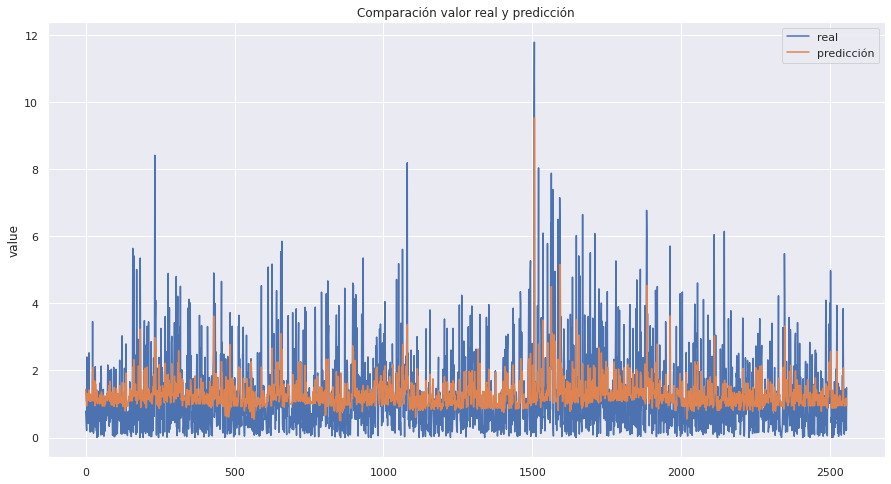

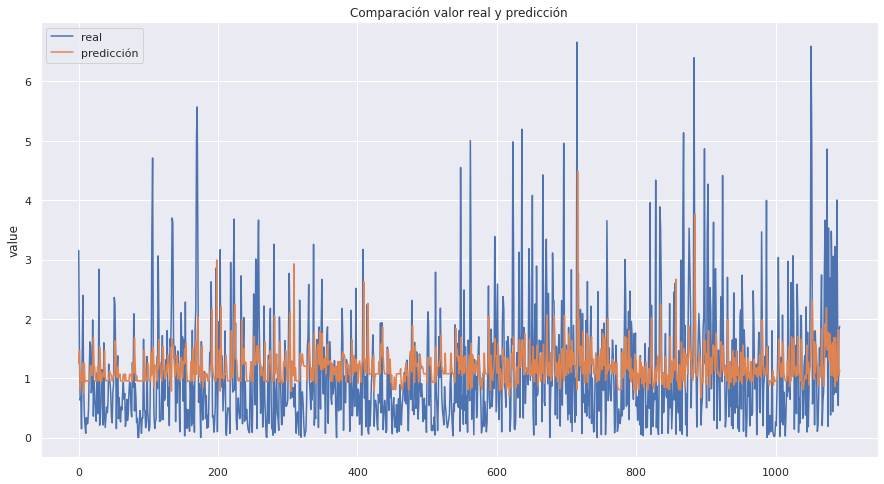

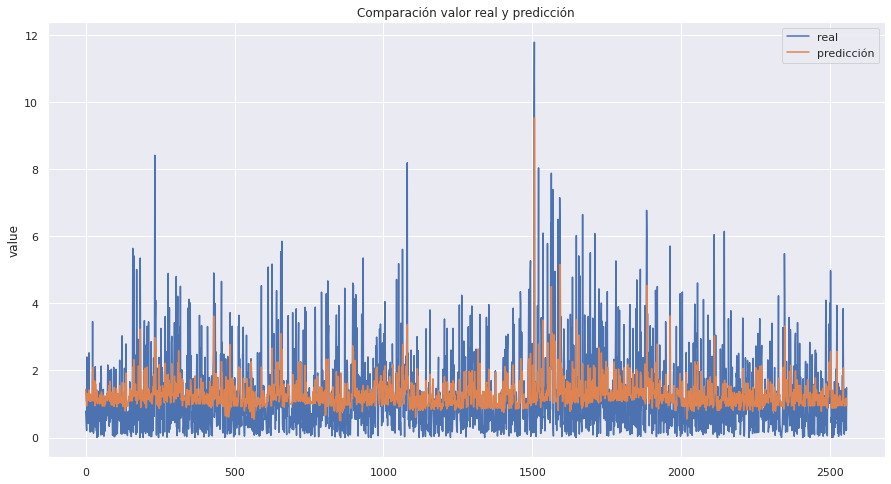

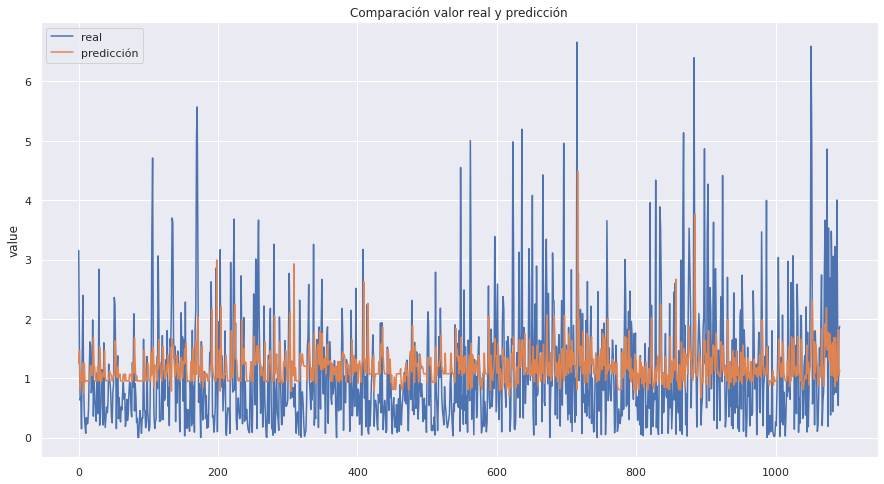

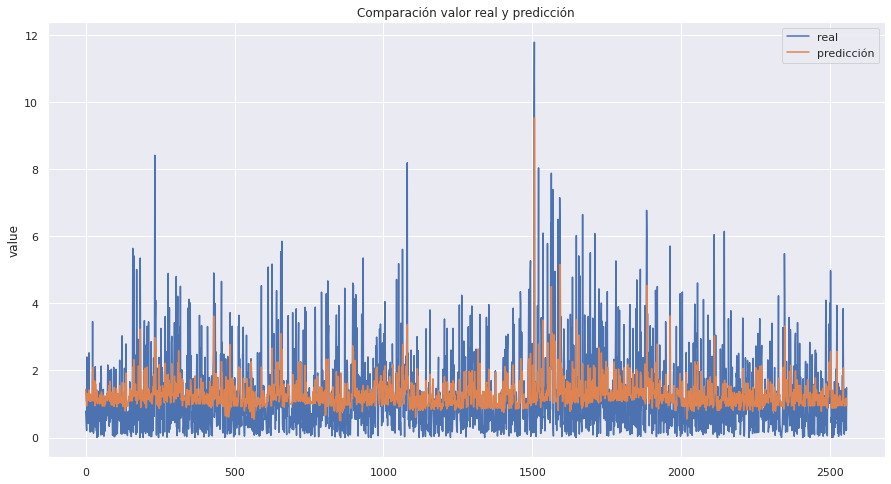

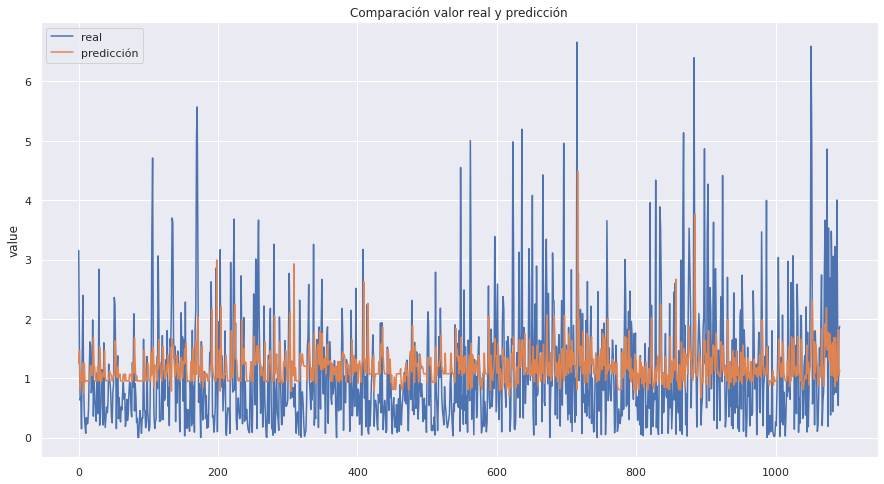

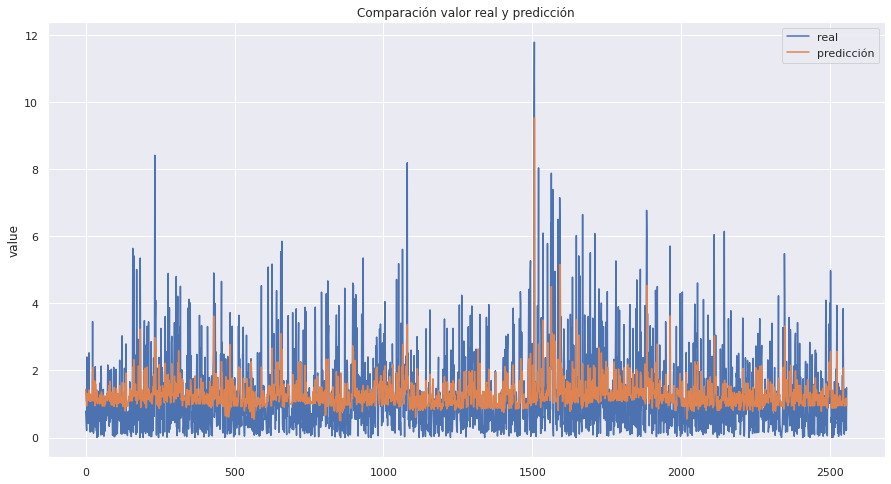

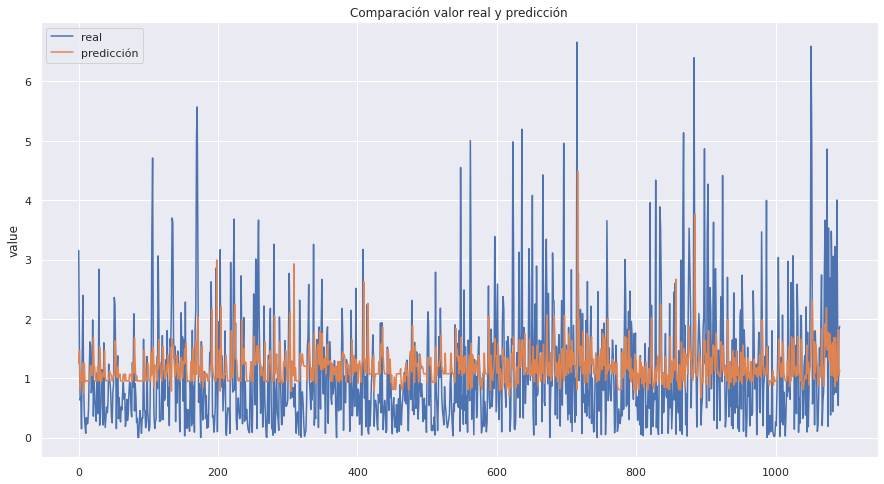

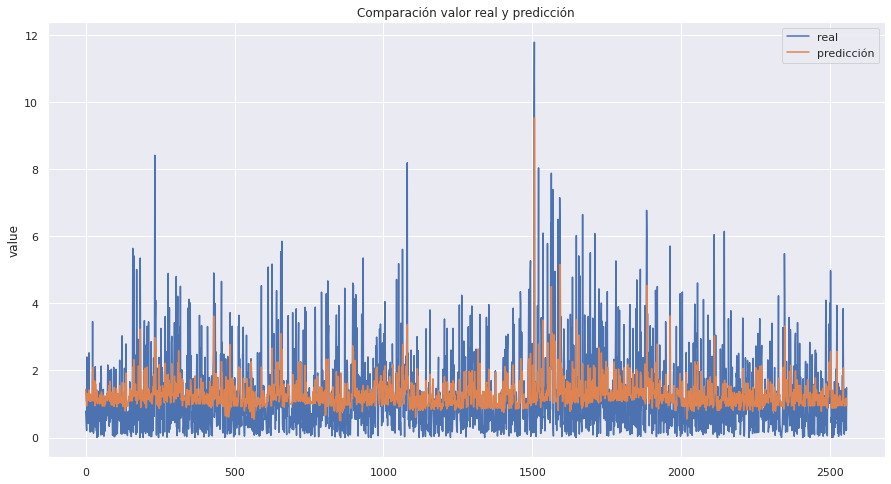

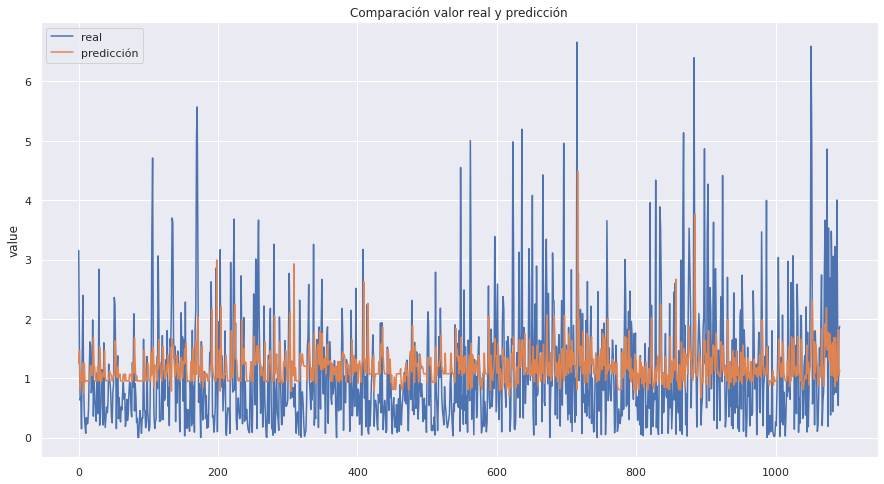

In [11]:
lags=[3,5,7,8,10,15]
n_estimators=[i for i in range(50,100,10)]
n_estimators.extend([200,300,500])
results_models={i:{} for i in lags}
for lg in lags:
    for est in n_estimators:
        results_models[lg][est]=Model(df_data.copy(),df_label.copy(),lg,est)